In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [00:09:06] Enabling RDKit 2019.09.3 jupyter extensions
[00:09:06] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  29978


number of successfully processed smiles:  29978


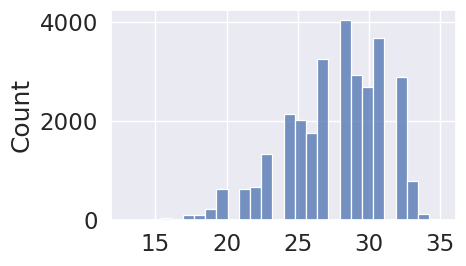

In [3]:
task_name = 'Photovoltaic efficiency'
tasks = ['PCE']

raw_filename = "../data/cep-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [4]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.15
fingerprint_dim = 200

weight_decay = 4.5 # also known as l2_regularization_lambda
learning_rate = 3.6
radius = 3
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,smiles,PCE,cano_smiles


In [6]:
test_df = remained_df.sample(frac=1/5,random_state=random_seed)
train_df = remained_df.drop(test_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# print(len(test_df),sorted(test_df.cano_smiles.values))

In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1145405
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':test_MAE, 'test_MAE':test_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':test_MAE, 'test_MSE':test_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 0.9:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)


0 29.351587 28.950857


1 5.2219043 5.0423017


2 3.3691115 3.140582


3 2.666329 2.4270577


4 2.7914608 2.548972


5 2.5309467 2.305953


6 2.3742273 2.163469


7 2.454553 2.2472706


8 2.39998 2.1878128


9 2.2742984 2.054821


10 2.3176413 2.0931


11 2.2303894 2.008295


12 2.0998952 1.8808835


13 2.1002316 1.8844843


14 2.032132 1.8259523


15 1.9769441 1.7621979


16 2.0362422 1.8303788


17 1.8692349 1.6665591


18 1.8592536 1.658239


19 1.8849138 1.6837908


20 1.811554 1.6320837


21 1.7932808 1.598213


22 1.7143143 1.5399531


23 1.6755002 1.5063044


24 1.6513515 1.4892637


25 1.6643252 1.4874089


26 1.5925281 1.428175


27 1.6345166 1.4629999


28 1.5981969 1.4281054


29 1.5720326 1.428536


30 1.5379683 1.3872256


31 1.5077566 1.3773215


32 1.4601994 1.318784


33 1.4258409 1.2869886


34 1.448206 1.3026954


35 1.4991387 1.3505592


36 1.4097191 1.2986543


37 1.3758763 1.2581953


38 1.4600362 1.3592815


39 1.3489221 1.2116302


40 1.2927179 1.2009549


41 1.2646984 1.1731777


42 1.2653624 1.162247


43 1.2455074 1.1442441


44 1.2377998 1.129503


45 1.310401 1.1835226


46 1.1936924 1.1358966


47 1.2093779 1.1579818


48 1.1182618 1.0617862


49 1.1972431 1.0951717


50 1.1027168 1.04971


51 1.1787091 1.0933298


52 1.0448111 0.9994059


53 1.1475624 1.0684258


54 1.0331955 1.0064274


55 1.0433725 1.0035273


56 1.1485103 1.0749092


57 1.0207789 1.0160247


58 1.0246298 1.0357875


59 1.0893531 1.036092


60 0.93630666 0.95577604


61 0.99144346 1.0397223


62 0.95709085 0.96031255


63 0.99244606 1.0310228


64 0.98669887 0.9827789


65 0.9010767 0.94821566


66 0.8924136 0.92361784


67 0.8875261 0.92719895


68 0.90673065 0.9435877


69 0.84862643 0.92380166


70 0.83060634 0.9256481


71 0.898995 0.9400439


72 0.8022514 0.8661991


73 0.8471587 0.9372756


74 0.81225777 0.8600483


75 0.7855201 0.8644811


76 0.8093695 0.8960054


77 0.7799445 0.89642805


78 0.75943047 0.89462435


79 0.71939224 0.8602001


80 0.72231835 0.85564417


81 0.82580537 0.95479655


82 0.746513 0.86232275


83 0.74156433 0.87534755


84 0.7213263 0.8730769


85 0.71232796 0.8495564


86 0.6721275 0.85918933


87 0.6981301 0.8494222


88 0.69627947 0.85133976


89 0.65212005 0.8017909


90 0.6834446 0.8567281


91 0.6457094 0.82238096


92 0.6679433 0.8145458


93 0.6057548 0.8209811


94 0.6144016 0.80435026


95 0.58295673 0.81323993


96 0.61372894 0.86158985


97 0.6459725 0.8879842


98 0.6623467 0.8829428


99 0.578925 0.8415399


100 0.6092798 0.84725755


101 0.58895415 0.8522135


102 0.5427295 0.77232224


103 0.5605213 0.8115337


104 0.5339749 0.79216546


105 0.5426102 0.7975706


106 0.5391954 0.8347762


107 0.48888224 0.7869395


108 0.484599 0.7836082


109 0.5061712 0.76811904


110 0.4941815 0.7808024


111 0.4638982 0.7693909


112 0.47326148 0.77121687


113 0.46850982 0.7869351


114 0.43836072 0.76403236


115 0.45951208 0.79171777


116 0.47476354 0.7885923


117 0.42649963 0.77248603


118 0.44478697 0.7760337


119 0.4463134 0.7607373


120 0.4365184 0.78927946


121 0.42410558 0.7672125


122 0.40290186 0.7812884


123 0.40355283 0.7606179


124 0.3949224 0.7923173


125 0.38523132 0.774539


126 0.3781923 0.7650188


127 0.4025866 0.77931786


128 0.3890838 0.8081558


129 0.35223615 0.7436879


130 0.3367762 0.7660247


131 0.4090781 0.8032242


132 0.37226325 0.7747115


133 0.3473528 0.78651613


134 0.34564808 0.8033727


135 0.35083804 0.7520652


136 0.32064575 0.7549786


137 0.3132555 0.75937533


138 0.35806546 0.7784731


139 0.32042632 0.77581346


140 0.33001432 0.7426611


141 0.30915773 0.779754


142 0.30814537 0.77175206


143 0.30088282 0.7514846


144 0.3148673 0.78450215


145 0.30817997 0.76523185


146 0.28224698 0.7616636


147 0.28111205 0.74040365


148 0.39924797 0.8584918


149 0.28590283 0.80511224


150 0.268487 0.7650823


151 0.4075177 0.8493406


152 0.25046787 0.7349182


153 0.2842276 0.7818261


154 0.255453 0.78631496


155 0.30060852 0.81685156


156 0.25620726 0.80315036


157 0.27112833 0.77666897


158 0.24731083 0.7752332


159 0.32267854 0.8002674


160 0.22996913 0.74654704


161 0.23443653 0.75649905


162 0.23448038 0.76792324


163 0.22264802 0.73715794


164 0.23102276 0.7546196


165 0.22627363 0.7454404


166 0.23599678 0.7548929


167 0.22693168 0.7665516


168 0.22852841 0.76189834


169 0.23828524 0.7759431


170 0.20759316 0.7381365


171 0.19334015 0.75650513


172 0.2124981 0.7407945


173 0.21418126 0.76387864


In [10]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(best_model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

best epoch: 152 
 test MSE: 0.7349182
